# Global Optimization with Gaussian Processes: Part2

The goal of this lab session is to use Bayesian optimization to tune the parameters of Machine Learning algorithms using different libraries.

# 1 Tuning the Parameters of Machine Learning algorithms

After learning some theory about Bayesian Optimization, let's have a look at how to use GPyOpt to tune the hyper-parameters of a practical algorithm. Here shows how to tune the hyper-parameters for Support Vector Regression (SVR) with the toy dataset that we have seen from Lab 1: the Olympic marathon dataset.

We split the original dataset into the training data (first 20 datapoints) and testing data (last 7 datapoints). The performance of SVR is evaluated in terms of Rooted Mean Squared Error (RMSE) on the testing data.

As in previous labs, we start loading the requires modules.

In [1]:
%matplotlib inline  
import GPy
import GPyOpt
import numpy as np
from numpy.random import seed
seed(12345)

In [2]:
# Let's load the dataset
GPy.util.datasets.authorize_download = lambda x: True # prevents requesting authorization for download.
data = GPy.util.datasets.olympic_marathon_men()
X = data['X']
Y = data['Y']
X_train = X[:20]
Y_train = Y[:20,0]
X_test = X[20:]
Y_test = Y[20:,0]

Let's first see the results with the default kernel parameters.

In [3]:
from sklearn import svm
svr = svm.SVR()
svr.fit(X_train,Y_train)
Y_train_pred = svr.predict(X_train)
Y_test_pred = svr.predict(X_test)
print("The default parameters obtained: C="+str(svr.C)+", epilson="+str(svr.epsilon)+", gamma="+str(svr.gamma))

The default parameters obtained: C=1.0, epilson=0.1, gamma=scale


We compute the RMSE on the testing data and plot the prediction. With the default parameters, SVR does not give an OK fit to the training data but completely miss out the testing data well.

RMSE = 0.33446835065565117


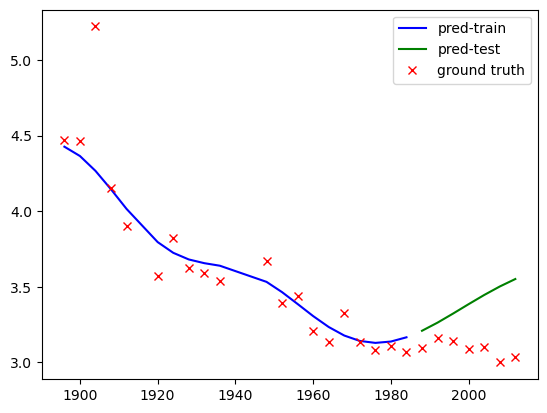

In [4]:
import matplotlib.pyplot as plt
plt.plot(X_train,Y_train_pred,'b',label='pred-train')
plt.plot(X_test,Y_test_pred,'g',label='pred-test')
plt.plot(X_train,Y_train,'rx',label='ground truth')
plt.plot(X_test,Y_test,'rx')
plt.legend(loc='best')
print("RMSE = "+str(np.sqrt(np.square(Y_test_pred-Y_test).mean())))

Now let's try **Bayesian Optimization**. We first write a wrap function for fitting with SVR. The objective is the RMSE from cross-validation. We optimize the parameters in *log* space.

In [5]:
nfold = 3
def fit_svr_val(x):
    x = np.atleast_2d(np.exp(x))
    fs = np.zeros((x.shape[0],1))
    for i in range(x.shape[0]):
        fs[i] = 0
        for n in range(nfold):
            idx = np.array(range(X_train.shape[0]))
            idx_valid = np.logical_and(idx>=X_train.shape[0]/nfold*n, idx<X_train.shape[0]/nfold*(n+1))
            idx_train = np.logical_not(idx_valid)
            svr = svm.SVR(C=x[i,0], epsilon=x[i,1],gamma=x[i,2])
            svr.fit(X_train[idx_train],Y_train[idx_train])
            fs[i] += np.sqrt(np.square(svr.predict(X_train[idx_valid])-Y_train[idx_valid]).mean())
        fs[i] *= 1./nfold
    return fs

We set the search interval of $C$ to be roughly $[0,1000]$ and the search interval of $\epsilon$ and $\gamma$ to be roughtly $[1\times 10^{-5},0.1]$.

In [6]:
bounds =[{'name': 'C', 'type': 'continuous', 'domain': (0.,7.)},
         {'name': 'epsilon', 'type': 'continuous', 'domain': (-12.,-2.)},
         {'name': 'gamma', 'type': 'continuous', 'domain': (-12.,-2.)}]

We, then, create the GPyOpt object and run the optimization procedure. It might take a while.

In [7]:
opt = GPyOpt.methods.BayesianOptimization(f = fit_svr_val,            # function to optimize       
                                             domain = bounds,         # box-constrains of the problem
                                             acquisition='LCB',       # LCB acquisition
                                             acquisition_par = 0.1)   # acquisition = Expected improvement

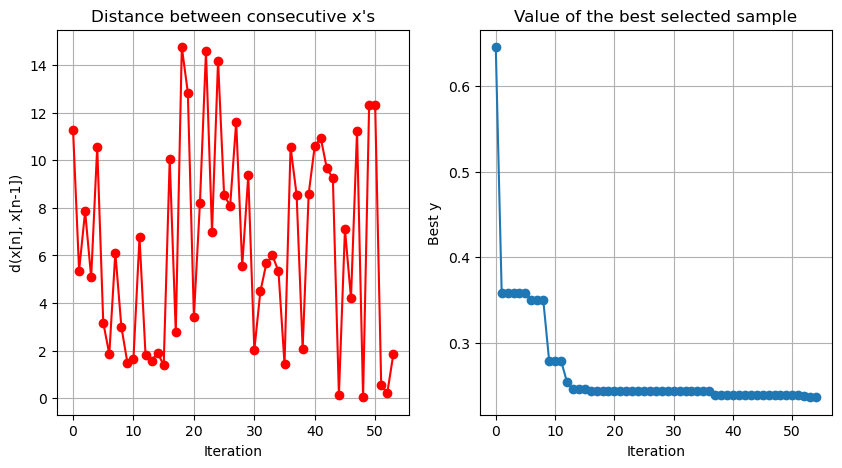

In [8]:
# it may take a few seconds
opt.run_optimization(max_iter=50)
opt.plot_convergence()

Let's show the best parameters found. They differ significantly from the default parameters.

In [9]:
x_best = np.exp(opt.X[np.argmin(opt.Y)])
print("The best parameters obtained: C="+str(x_best[0])+", epilson="+str(x_best[1])+", gamma="+str(x_best[2]))
svr = svm.SVR(C=x_best[0], epsilon=x_best[1],gamma=x_best[2])
svr.fit(X_train,Y_train)
Y_train_pred = svr.predict(X_train)
Y_test_pred = svr.predict(X_test)

The best parameters obtained: C=233.97617719384024, epilson=0.1067469568175546, gamma=8.340717051287002e-06


We can see SVR does a reasonable fit to the data. The result could be further improved by increasing the *max_iter*. 

RMSE = 0.0769865291130618


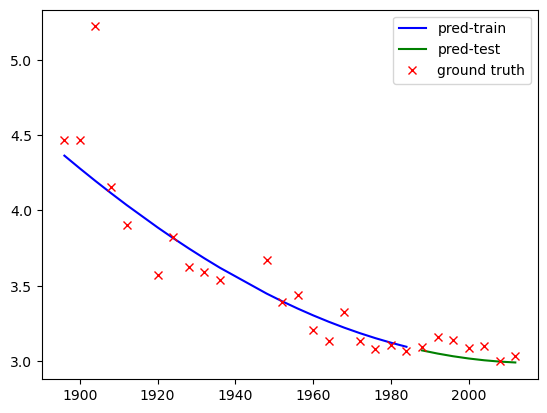

In [10]:
plt.plot(X_train,Y_train_pred,'b',label='pred-train')
plt.plot(X_test,Y_test_pred,'g',label='pred-test')
plt.plot(X_train,Y_train,'rx',label='ground truth')
plt.plot(X_test,Y_test,'rx')
plt.legend(loc='best')
print("RMSE = "+str(np.sqrt(np.square(Y_test_pred-Y_test).mean())))

### Exercise 1

1.1 Why we do not directly use the RMSE of the whole training dataset as the objective? Why bother with cross-validation?

In [11]:
## 1.1 Answer here 



2.1 Write a small comparative study to opimize the paramters of the SVR in the marathon data by changing the acquistion function and the model for the RMSE. Use the options that you learned yesterday. Comment on the results.

In [12]:
## 1.2 Answer here 



### Exercise 2

Select your favourite Machine Learning algorithm for [scikit-learn](http://scikit-learn.org/stable/), find and interesting data set (for instance form the [UCI  repository](http://archive.ics.uci.edu/ml/) and tune the parameters of your algorithm using GPyOpt. Use the code of this notebook as reference and be creative!

In [13]:
## 2 Answer here 




There are numerous Bayesian optimization libraries out there which include different functionalities and algorithms.

### Scikit-optimize

[Scikit-optimize](https://scikit-optimize.github.io/) is a library for sequential model-based optimization that is based on [scikit-learn](http://scikit-learn.org/). It also supports Bayesian optimization using Gaussian processes. The API is designed around minimization, hence, we have to provide negative objective function values.  The results obtained here slightly differ from previous results because of non-deterministic optimization behavior and different noisy samples drawn from the objective function.

In [14]:
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern

#Repeat the hyperparameter tunning process using Scikit-optimize instead of GpyOpt.


ModuleNotFoundError: No module named 'skopt'